### Imports

In [1]:
from XRDXRFutils import DatabaseXRD, DataXRD, SpectraXRD, GaussNewton, PhaseList, PhaseMap, PhaseSearch, PhaseMapSave

import os
import pickle
import numpy as np
import scipy as sp
from joblib import Parallel, delayed
import h5py
from sklearn.linear_model import LinearRegression

#import matplotlib
#import matplotlib.pyplot as plt
#from matplotlib.colors import LogNorm
#from matplotlib.markers import MarkerStyle
from matplotlib.pyplot import imshow,subplots,plot,xlim,ylim,xlabel,ylabel,cm

from PIL import Image

#### Define Paths

In [2]:
path_xrd = '/home/shared/dataXRDXRF/MuseoEgizio2022/VoltoGeroglifici/'
path_database = '/home/shared/DatabaseXRD'

path_data = 'data/' # data of intermediate results, for fast loading
path_figures = 'figures/' # figures generated by the script
path_results = 'results/' # results generated by the script: raw data, tif maps

#### Spectra parameters

In [3]:
min_theta = 20
max_theta = 53
min_intensity = 0.1 # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None # selects the first n most intense peaks (if None, leaves all the peaks)

#### Read XRD Data

from xrd.h5

In [4]:
data = DataXRD().load_h5(path_xrd + 'xrd.h5')

Loading: /home/shared/dataXRDXRF/MuseoEgizio2022/VoltoGeroglifici/xrd.h5


#### Read raw XRD Data

This is disabled. To enable change cell type from raw to code.

#### Display datacube

This is only to check. Shows sum across the spectra dimension.

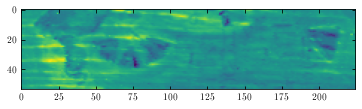

In [5]:
imshow(data.data.sum(axis=2))

For the large datacubes the datasize can be easily reduced using [::n,::n]
where every $n$th pixel is taken

Notes:
Please keep in mind that this rewrites the original dataset so to return the datacube must be reloaded

In [6]:
data.data = data.data[::3,::3]

Display reduced datacube

when $n=3$ every third pixel is taken 

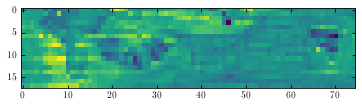

In [7]:
imshow(data.data.sum(axis=2))

#### Print calibration parameters

In [6]:
print("a: %.1f s: %.1f beta: %.3f"%(data.opt[0],data.opt[1],data.opt[2]))

a: -1327.1 s: 2729.8 beta: 43.202


#### Read database

In [7]:
database = DatabaseXRD().read_cifs(path_database)
print('Phases in database:',len(database))

Phases in database: 117


#### Define Phases

This is for simplification. Phases can be selected iteratively from database using 'Tab'

In [8]:
lazurite = database['Lazurite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][1]
barite = database['Barite'][0]
spinel = database['Spinel'][0]
calcite = database['Calcite'][0]
hematite = database['Hematite'][4]

orpiment = database['Orpiment'][0]
cuprorivaite = database['Cuprorivaite'][0]

### Autocalibration and Phase Search

Takes 'data' and a list of phases to search for. Searches for phases iterating both $a$ and $s$.

In [9]:
phases_a_s = PhaseList([hematite,orpiment,cuprorivaite])

PhaseMap construct a data structures for the minimization.

In [10]:
%%time
pm = PhaseMap(data, phases_a_s,
              min_theta = min_theta,
              max_theta = max_theta,
              min_intensity = min_intensity,
              first_n_peaks = first_n_peaks)

CPU times: user 40.7 s, sys: 3.81 s, total: 44.5 s
Wall time: 50.6 s


#### Autocalibration and Search
Iterates $a$ $s$ and $\gamma$

In [32]:
%%time
pm.search()

CPU times: user 1min 46s, sys: 15.6 s, total: 2min 2s
Wall time: 2min 22s


#### Display loss for each phase

In [33]:
loss = pm.fit_error()
opt = pm.opt()
a = opt[...,0]
s = opt[...,1]

In [34]:
opt.shape

(54, 225, 3)

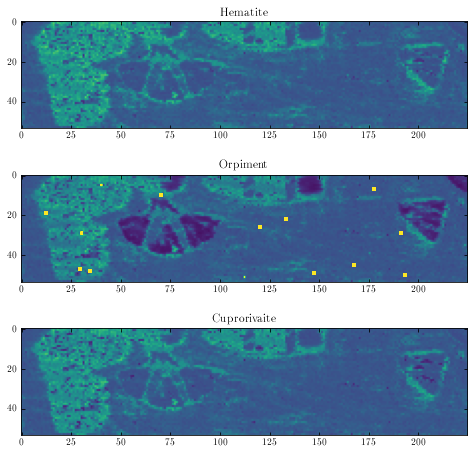

In [44]:
fig,ax = subplots(3,1,figsize=(8,8))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    ax[i].imshow(loss[:,:,i],vmin=0,vmax=0.4)

Text(0, 0.5, '$s$')

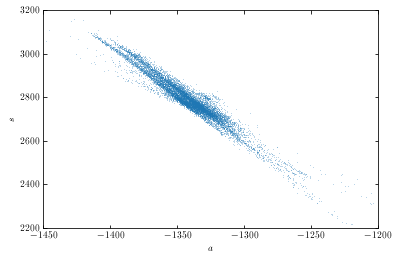

In [57]:
f = loss.min(axis=2).flatten()<0.2

plot(a.flatten()[f],s.flatten()[f],',',alpha=0.3)
xlim(-1450,-1200)
ylim(2200,3200)
xlabel(r'$a$')
ylabel(r'$s$')